# Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from imblearn.over_sampling import SMOTE as smote
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss, AllKNN, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Parse Data

In [2]:
# Load the data from the CSV
df = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int}, na_filter=False)

# We are not interested in these columns (using booking date would be cheating)
df = df.drop(['txid','bookingdate'], axis='columns')

# Use column names which are more recognizable
df = df.rename(index=str, columns={'issuercountrycode':'issuercountry', 
                                   'bin':'issuer_id', 
                                   'shoppercountrycode':'shoppercountry', 
                                   'shopperinteraction':'interaction', 
                                   'cardverificationcodesupplied':'verification', 
                                   'cvcresponsecode':'cvcresponse', 
                                   'creationdate':'creationdate_stamp', 
                                   'simple_journal':'label'}) 

# Skip data if:
df = df[df['label']!='Refused']
df = df[~df['issuer_id'].str.contains('na', case=False)]
df = df[~df['mail_id'].str.contains('na', case=False)]

# Create and format (new) columns
df['creationdate'] = (pd.to_datetime(df['creationdate_stamp'])).dt.date
df['issuer_id'] = pd.to_numeric(df['issuer_id'])
df['mail_id'] = pd.to_numeric(df['mail_id'].str.replace('email','')).astype(int)
df['ip_id'] = pd.to_numeric(df['ip_id'].str.replace('ip','')).astype(int)
df['card_id'] = pd.to_numeric(df['card_id'].str.replace('card','')).astype(int)
df['subscription'] = pd.to_numeric(df['interaction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))
df['verification'] = pd.to_numeric(df['verification'].apply(lambda x: '1' if x else '0'))

# Label the data
df['label'] = pd.to_numeric(df['label'].apply(lambda x: '1' if x == 'Chargeback' else '0'))

# Preprocess Data

In [3]:
# USD conversion rate
converter = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}


# Function that can take two input values (amount, currency) and convert it to USD (using current ratios, not historic ones)
def convert_to_usd(args):
    amount, currency = args
    return converter[currency] * amount / 100

# Create a new column containing the transaction amount in USD to be able to compare the transaction amounts.
df['usd_amount'] = df[['amount', 'currencycode']].apply(convert_to_usd, axis=1)

# Add a feature that checks if shopper and issuer country is equal
df.loc[df['shoppercountry'] == df['issuercountry'], 'home_country'] = 1
df.loc[df['shoppercountry'] != df['issuercountry'], 'home_country'] = 0

# Create new dataframe with average expense per customer
avg_expense = df.groupby('card_id')['usd_amount'].mean().reset_index().rename(columns={'usd_amount': 'avg_amount'})
# Merge this new dataframe with our parsed dataset to obtain a column with average amounts
df = pd.merge(df, avg_expense, on='card_id', how='left')
# We are actually mainly interested in the difference between 
# the average transaction amount of this customer and the current transaction amount.
df['dif_avg_amount'] = df['usd_amount'] - df['avg_amount']

# Number of transactions in this country
ntc = df.groupby(['card_id', 'shoppercountry'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'ntc'})
df = pd.merge(df, ntc, on=['card_id', 'shoppercountry'], how='left')

# Number of transactions for this interaction type
nti = df.groupby(['card_id', 'interaction'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'nti'})
df = pd.merge(df, nti, on=['card_id', 'interaction'], how='left')

In [4]:
print("Total amount:", len(df))
fraud = df[df['label']==1]
benign = df[df['label']==0]

Total amount: 236698


# Find interesting relationships in the data

In [5]:
number_of_fraudulent_cases = len(fraud)
print("Number of fraudulent cases:", number_of_fraudulent_cases)

number_of_benign_cases = len(benign)
print("Number of benign cases:", number_of_benign_cases)

Number of fraudulent cases: 345
Number of benign cases: 236353


In [6]:
not_same_country_benign = benign[benign['home_country'] != 1]
not_same_country_fraud = fraud[fraud['home_country'] != 1]
print("Fraction of benign data not in home country", len(not_same_country_benign) / len(benign))
print("Fraction of fraud data not in home country", len(not_same_country_fraud) / len(fraud))

Fraction of benign data not in home country 0.02904976877805655
Fraction of fraud data not in home country 0.04057971014492753


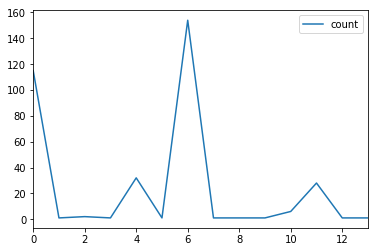

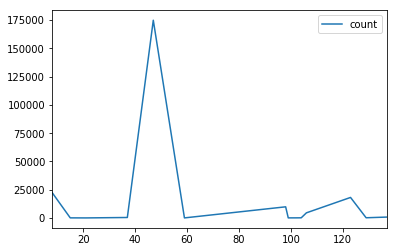

In [7]:
# The raw amounts from the fraud/benign transactions per country were further 
# processed in libre office to produce the graphs contained in the report (due to bug in pandas for python < 3.7).
amount_fraud_per_country = fraud.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
fraudulent_countries = list(amount_fraud_per_country['shoppercountry'])
amount_fraud_per_country.plot()

amount_benign_per_country = benign.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
amount_benign_per_country = amount_benign_per_country[pd.DataFrame(amount_benign_per_country.shoppercountry.tolist()).isin(fraudulent_countries).any(1)]
amount_benign_per_country.plot()

In [8]:
# Calculate average transaction amounts.
avg_usd_amount_fraud = fraud['usd_amount'].mean()
avg_usd_amount_benign = benign['usd_amount'].mean()
print("Average amount in USD for the fraudulent cases:", round(avg_usd_amount_fraud, 2))
print("Average amount in USD for the benign cases:", round(avg_usd_amount_benign, 2))

Average amount in USD for the fraudulent cases: 162.81
Average amount in USD for the benign cases: 87.06


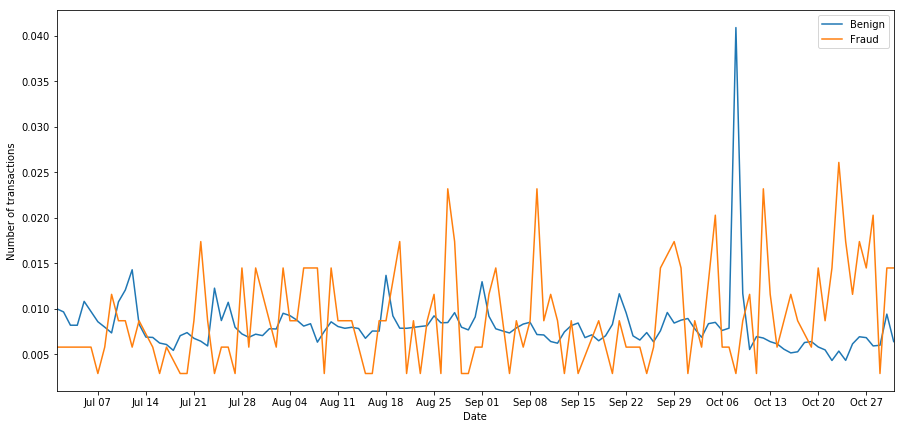

In [9]:
# Plot the fraction of fraudulent/benign transactions per day
d_benign = benign.groupby('creationdate')['amount'].agg(['count']).rename(columns={'count': 'Benign'})
d_benign['Benign'] = d_benign['Benign'] / len(benign)
d_fraud = fraud.groupby('creationdate')['amount'].agg(['count']).rename(columns={'count': 'Fraud'})
d_fraud['Fraud'] = d_fraud['Fraud'] / len(fraud)

plt.figure(1, figsize=(15,7))
fig = plt.gcf()
ax = plt.gca()

d_benign.plot(ax=ax)
d_fraud.plot(ax=ax)
ax.set(xlabel="Date", ylabel="Number of transactions")
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Compare sampling methods using ROC and AUC

In [20]:
# Function to compare a sampling method and plot both results in the same graph
def compare_sampling(classifier, classifier_name, sampling_name, train_ft, train_ft_sampled, test_ft, train_lbl, train_lbl_sampled, test_lbl):
    fig = plt.figure()
    
    # Individual train and calculating results
    plot_line_compare_sampling(classifier, classifier_name, 'normal', train_ft, test_ft, train_lbl, test_lbl)
    plot_line_compare_sampling(classifier, classifier_name, sampling_name, train_ft_sampled, test_ft, train_lbl_sampled, test_lbl)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of %s and no %s for a %s' % (sampling_name, sampling_name, classifier_name))
    plt.legend(loc="lower right")
#     plt.savefig(f'{sampling_name}_{classifier_name}.png')
    plt.show()
    return classifier
    
# Function that trains a model and calculate scores.
def plot_line_compare_sampling(classifier, classifier_name, line_label, train_ft, test_ft, train_lbl, test_lbl):
    classifier.fit(train_ft, train_lbl)
    
    predict_lbl = classifier.predict_proba(test_ft)
    predict_lbl = predict_lbl[:, 1]
    
    predict_decision_lbl = classifier.predict(test_ft)
    print(line_label+':')
    print(confusion_matrix(test_lbl, predict_decision_lbl))
    
    #Calculate ROC and AUC
    fp_rate, tp_rate, _ = roc_curve(test_lbl, predict_lbl, pos_label =True)
    area = auc(fp_rate, tp_rate)
    plt.plot(fp_rate, tp_rate, label=('ROC %s (area = %0.2f)') %(line_label, area))

# Function that executes 5 different classifier to see the results for different sampling methods
def try_sampling(sampler, sampler_name):
    features_to_use = ['usd_amount', 'dif_avg_amount', 'ntc', 'home_country', 'cvcresponse', 'verification']
    data_ft = df[features_to_use].values
    data_lbl = df[['label']].values.ravel()

    train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)
    train_ft_sampled, train_lbl_sampled = sampler.fit_sample(train_ft,train_lbl)

    cl1 = compare_sampling(DecisionTreeClassifier(max_depth=4), "Decision Tree", sampler_name, train_ft, train_ft_sampled, test_ft, train_lbl, train_lbl_sampled, test_lbl)
    cl2 = compare_sampling(RandomForestClassifier(n_estimators=10), "Random Forest", sampler_name, train_ft, train_ft_sampled, test_ft, train_lbl, train_lbl_sampled, test_lbl)
    cl3 = compare_sampling(GaussianNB(), "Gaussian Naive Bayes", sampler_name, train_ft, train_ft_sampled, test_ft, train_lbl, train_lbl_sampled, test_lbl)
    cl4 = compare_sampling(AdaBoostClassifier(), "Ada Boost", sampler_name, train_ft, train_ft_sampled, test_ft, train_lbl, train_lbl_sampled, test_lbl)
    cl4 = compare_sampling(GradientBoostingClassifier(), "Gradient Boosting", sampler_name, train_ft, train_ft_sampled, test_ft, train_lbl, train_lbl_sampled, test_lbl)

# Sampling Methods

### SMOTE

normal:
[[47287     0]
 [   53     0]]
SMOTE:
[[38933  8354]
 [   10    43]]


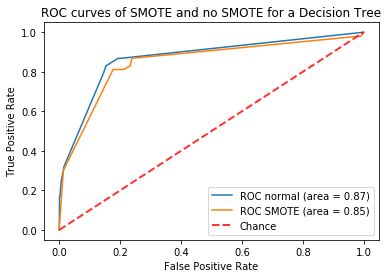

normal:
[[47276    11]
 [   49     4]]
SMOTE:
[[46336   951]
 [   34    19]]


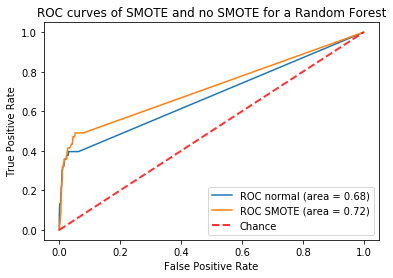

normal:
[[46968   319]
 [   42    11]]
SMOTE:
[[39052  8235]
 [   10    43]]


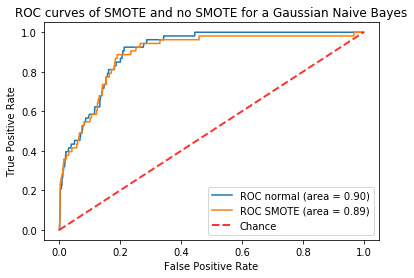

normal:
[[47286     1]
 [   53     0]]
SMOTE:
[[39784  7503]
 [   10    43]]


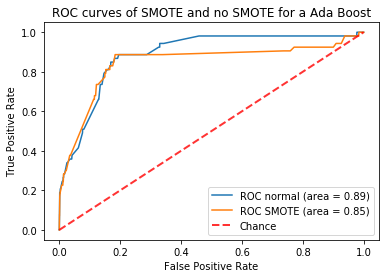

normal:
[[47279     8]
 [   53     0]]
SMOTE:
[[40568  6719]
 [   12    41]]


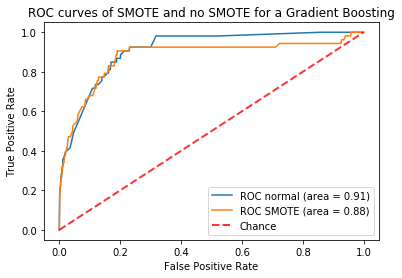

In [12]:
sm = smote(sampling_strategy = 'minority')
try_sampling(sm, 'SMOTE')

### Random Under Sampler

normal:
[[47270     0]
 [   70     0]]
Random Under Sampling:
[[38158  9112]
 [   10    60]]


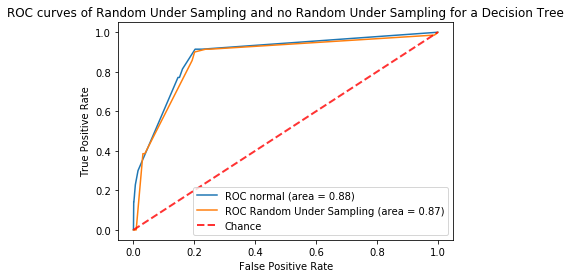

normal:
[[47261     9]
 [   63     7]]
Random Under Sampling:
[[38285  8985]
 [    9    61]]


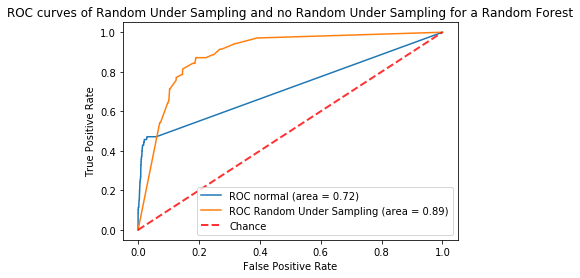

normal:
[[46894   376]
 [   62     8]]
Random Under Sampling:
[[37727  9543]
 [   12    58]]


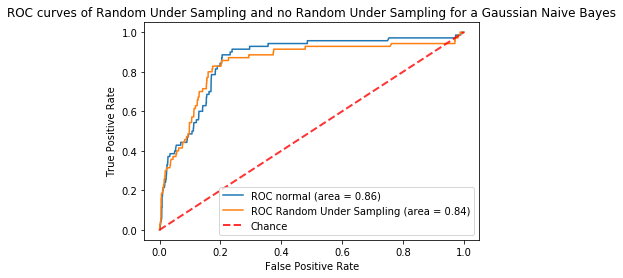

normal:
[[47265     5]
 [   70     0]]
Random Under Sampling:
[[38393  8877]
 [    6    64]]


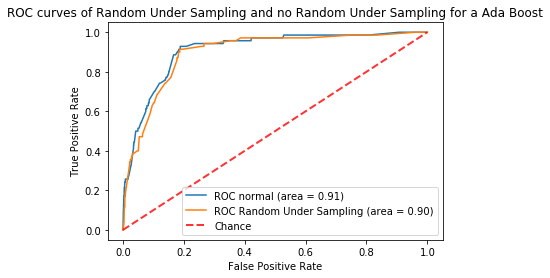

normal:
[[47266     4]
 [   69     1]]
Random Under Sampling:
[[38525  8745]
 [    9    61]]


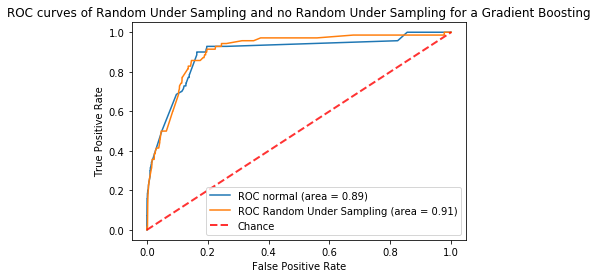

In [15]:
sm = RandomUnderSampler()
try_sampling(sm, 'Random Under Sampling')

### Near Miss

normal:
[[47272     2]
 [   66     0]]
Near Miss:
[[ 5114 42160]
 [   30    36]]


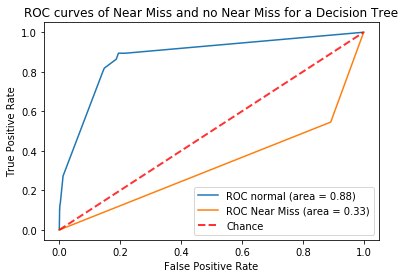

normal:
[[47259    15]
 [   61     5]]
Near Miss:
[[ 1213 46061]
 [   16    50]]


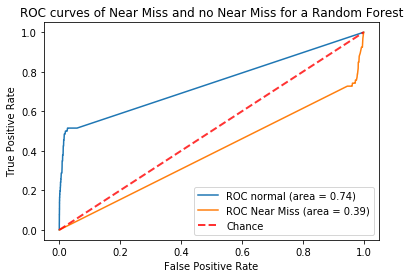

normal:
[[46884   390]
 [   58     8]]
Near Miss:
[[ 5924 41350]
 [   39    27]]


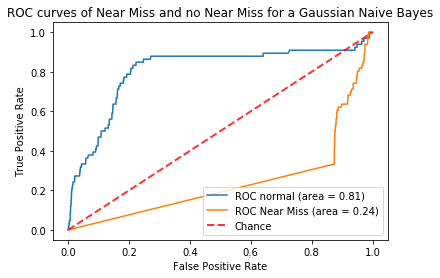

normal:
[[47271     3]
 [   66     0]]
Near Miss:
[[ 3152 44122]
 [   21    45]]


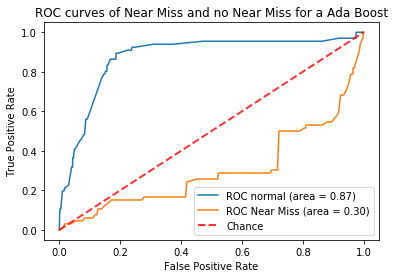

normal:
[[47266     8]
 [   62     4]]
Near Miss:
[[ 1461 45813]
 [   15    51]]


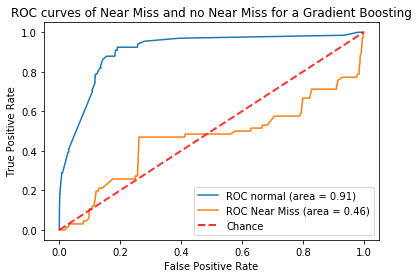

In [17]:
sm = NearMiss()
try_sampling(sm, 'Near Miss')